### SIRSDE example

In [1]:
from functools import partial

import jax
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from pyrox.losses import SoftContrastiveEstimationLoss
from functools import partial
import jax.numpy as jnp
from spyrox.train import rounds_based
from spyrox.sirsde import SIRSDEGuide, SIRSDEModel

### Define the model

In [2]:
key, subkey = jr.split(jr.key(1))
model = SIRSDEModel(subkey)

key, subkey = jr.split(key)
guide = SIRSDEGuide(subkey)

### Generate toy data

In [3]:
# simulated obs
key, subkey = jr.split(key)
true_latents = model.sample(subkey)
obs = true_latents.pop("x")

### Fit posterior

In [4]:
key, subkey = jr.split(key)

surrogate_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(2e-3), max_consecutive_errors=10),
    "max_epochs": 500,
}

guide_fit_kwargs = {
    "optimizer": optax.apply_if_finite(optax.adam(1e-3), max_consecutive_errors=10),
    "loss_fn": partial(
        SoftContrastiveEstimationLoss(n_particles=2, alpha=0.75),
        obs=obs,
        ),
    "steps": 1000,
}

(model, guide), losses =  rounds_based(
    key=subkey,
    model=model,
    guide=guide,
    num_rounds=5,
    sim_per_round=1000,
    obs=obs,
    surrogate_fit_kwargs=surrogate_fit_kwargs,
    guide_fit_kwargs=guide_fit_kwargs,
    simulator_param_name="z",
    obs_name= "x",
)



100%|██████████| 1000/1000 [00:21<00:00, 45.70it/s, loss=0.726]


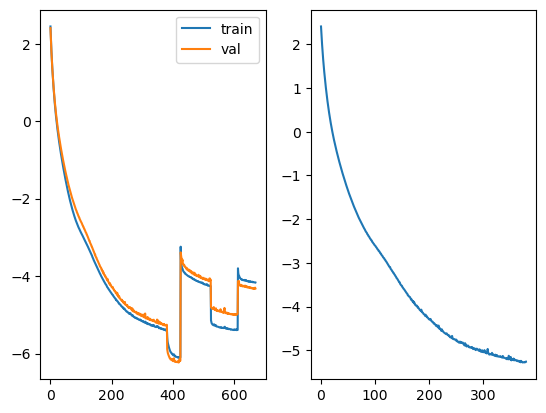

In [19]:
fig, axes = plt.subplots(ncols=2)

for k, loss_vals_round in losses["surrogate"].items():
    vals = [l for loss_vals in loss_vals_round for l in loss_vals]
    axes[0].plot(vals, label=k)
axes[0].legend()
axes[1].plot(jnp.asarray(losses["guide"]))


In [20]:
key, subkey = jr.split(key)
posterior = jax.vmap(partial(guide.sample, obs=obs))(jr.split(key, 1000))

key, subkey = jr.split(key)
joint_samples = jax.vmap(model.sample)(jr.split(key, 1000))


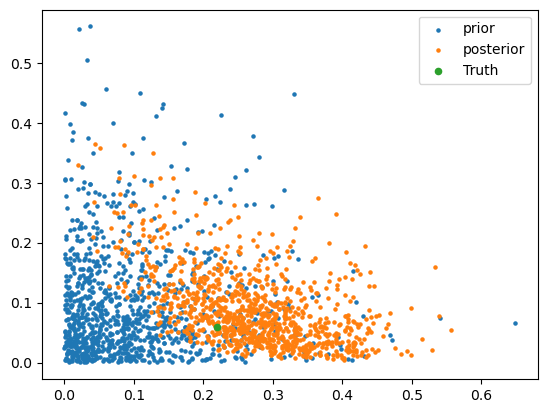

In [22]:
param1 = "infection_rate"
param2 = "r0_volatility"

plt.scatter(
    joint_samples[param1],
    joint_samples[param2],
    label="prior",
    s=5,
)

plt.scatter(
    posterior[param1],
    posterior[param2],
    label="posterior",
    s=5,
)


plt.scatter(
    true_latents[param1],
    true_latents[param2],
    label="Truth",
    s=20,
)

plt.legend()

